<a href="https://colab.research.google.com/github/parsa-abbasi/Sentiment-Analysis/blob/master/DeepLearning/DL_FastTextEmb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

## Get FastText

Download FastText word vectors file for Persian

(The list of all model vector files are available [here](https://fasttext.cc/docs/en/pretrained-vectors.html))

In [1]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fa.vec

--2019-11-27 12:04:16--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fa.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1105157170 (1.0G) [binary/octet-stream]
Saving to: ‘wiki.fa.vec’

wiki.fa.vec         100%[===================>]   1.03G  11.5MB/s    in 93s     

2019-11-27 12:05:50 (11.3 MB/s) - ‘wiki.fa.vec’ saved [1105157170/1105157170]



## Install required libraries

In [2]:
!pip install hazm
!pip install stopwords_guilannlp

     |████████████████████████████████| 317kB 6.5MB/s 
     |████████████████████████████████| 1.4MB 39.4MB/s 
     |████████████████████████████████| 235kB 35kB/s 
  Created wheel for nltk: filename=nltk-3.3-cp36-none-any.whl size=1394469 sha256=643737751fd5fda549fcbd8c81aa99c3c958e03ecf17b97bea7ff43810aef757
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp36-cp36m-linux_x86_64.whl size=153927 sha256=55cb16bd081375335f782fc5e3a62e256e6486f8c9c4d2b4a39c2c73e87961c6
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
Successfully built nltk libwapiti
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


## Import Libraries

In [0]:
# General
import numpy as np
import pandas as pd
import codecs
# Word Embedding
from gensim.models import KeyedVectors
# Keras
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding, Dropout
from keras.layers import GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.utils.np_utils import to_categorical
from keras.metrics import categorical_accuracy
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Preprocessing
from stopwords_guilannlp import stopwords_output
from hazm import *
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt

# Upload dataset files

Upload dataset files to colab environment

You can access to dataset files through following links:

(x_train, x_test, y_train, y_test)
- [Original dataset](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/Original)
- [Balanced with extra data](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/BalancedWithExtra)
- [Data Augmentation - Full Translate](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/FullTranslate)
- [Data Augmentation - Synonyms](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/Synonyms)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving x_test.csv to x_test.csv
Saving x_train.csv to x_train.csv
Saving y_test.csv to y_test.csv
Saving y_train.csv to y_train.csv



# Import & Analyze Dataset

In [0]:
x_train = pd.read_csv('x_train.csv', sep='\t', index_col=None, header=None, encoding="utf-8")[1]
x_test = pd.read_csv('x_test.csv', sep='\t', index_col=None, header=None, encoding="utf-8")[1]
y_train = pd.read_csv('y_train.csv', sep='\t', index_col=None, header=None)[1]
y_test = pd.read_csv('y_test.csv', sep='\t', index_col=None, header=None)[1]

In [0]:
# The dataset csv files created using old version of Pandas
# so we need to do some additional preparation
x_train = x_train[1:]
x_train = x_train.reset_index(drop=True)
x_test = x_test[1:]
x_test = x_test.reset_index(drop=True)
y_train = y_train[1:]
y_train = y_train.reset_index(drop=True)
y_test = y_test[1:]
y_test = y_test.reset_index(drop=True)

In [7]:
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of training sentence:  (7023,)
Number of training label:  (7023,)
Number of testing sentence:  (1854,)
Number of testing label:  (1854,)


In [0]:
# Convert dataframes to numpy arrays
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [9]:
# See the data number of sentence in each category 
from collections import Counter
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

{0: 2000, 1: 2000, 2: 1928, -1: 937, -2: 158}


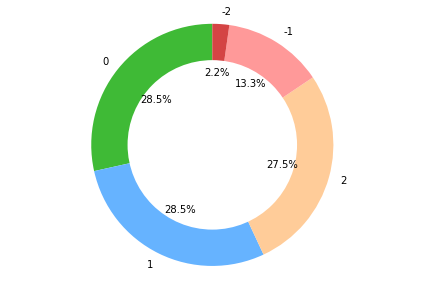

In [10]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

# Preprocess

In [0]:
# Customize preprocessing
puncs = ['،', '.', ',', ':', ';', '"']

# Hazm library
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# Apply preprocessing to a document
def clean_doc(doc):
  # Normalize document
  doc = normalizer.normalize(doc)
  # Tokenize text
  tokenized = word_tokenize(doc)
  # Remove punctuation
  tokens = []
  for t in tokenized:
    temp = t
    for p in puncs:
      temp = temp.replace(p, '')
    if temp.isdigit():
      tokens.append('<DIGIT>')
    else:
      tokens.append(temp)
  # Remove stop words
  # tokens = [w for w in tokens if not w in stop_set]
  # Remove one length words
  tokens = [w for w in tokens if not len(w) <= 1]
  # Remove digits
  #tokens = [w for w in tokens if not w.isdigit()]
  # Lemmatize sentence words using Hazm Lemmatizer
  tokens = [lemmatizer.lemmatize(w) for w in tokens]
  # Merge tokens to a single string
  tokens = ' '.join(tokens)
  return tokens

# Prepare FastText Model

In [12]:
EMBEDDING_FILE = 'wiki.fa.vec'

def import_with_gensim(file_address):
  # Creating the model
  ft_model = KeyedVectors.load_word2vec_format(file_address)
  # Getting the tokens
  ft_words = []
  for ft_word in ft_model.vocab:
      ft_words.append(ft_word)
  return ft_model, ft_words
  
ft_model, ft_words = import_with_gensim(EMBEDDING_FILE)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# FastText embedding dimensionality
embed_size = 300

In [0]:
# We get the mean and standard deviation of the embedding weights so that we could maintain the
# same statistics for the rest of our own random generated weights.
embedding_list = list()
for w in ft_words:
  embedding_list.append(ft_model[w])

all_embedding = np.stack(embedding_list)
emb_mean, emb_std = all_embedding.mean(), all_embedding.std()

# Prepare data for Deep Learning model

## Apply preprocessing to data

In [0]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

In [0]:
# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

## Setting tokenizer up

In [0]:
num_words = 2000

# Create the tokenizer
tokenizer = Tokenizer(num_words=num_words)

# fFt the tokenizer on the training documents
tokenizer.fit_on_texts(train_docs)

In [0]:
# Find maximum length of training sentences
max_length = max([len(s.split()) for s in train_docs])

## Embed sentences

In [0]:
# Embed training sequences
encoded_docs = tokenizer.texts_to_sequences(train_docs)

# Pad embeded training sequences
x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [0]:
# Define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index)

In [21]:
# We are going to set the embedding size to the pre-trained dimension as we are replicating it
nb_words = len(tokenizer.word_index)

# the size will be Number of Words in Vocab X Embedding Size
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

# With the newly created embedding matrix, we'll fill it up with the words that we have in both
# our own dictionary and loaded pre-trained embedding.
embeddedCount = 0
for word, i in tokenizer.word_index.items():
    i -= 1
    # then we see if this word is in glove's dictionary, if yes, get the corresponding weights
    if word in ft_model.vocab:
        embedding_vector = ft_model[word]
        # and store inside the embedding matrix that we will train later on.
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
    else:   # Unknown words
        embedding_vector = ft_model['subdivision_name']
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1

print('total embedded:', embeddedCount, 'common words')
print('Embedding matrix shape:', embedding_matrix.shape)

total embedded: 6871 common words
Embedding matrix shape: (6871, 300)


In [0]:
# Embed testing sequences
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# Pad testing sequences
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# Deep Learning Models

In [0]:
# Prepare labels for categorical prediction
categorical_y_train = to_categorical(y_train, 5)
categorical_y_test = to_categorical(y_test, 5)

## B-LSTM Model

In [0]:
model_blstm = Sequential()
model_blstm.add(Embedding(vocab_size, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False))
model_blstm.add(Bidirectional(CuDNNLSTM(300, return_sequences=True, name='lstm_layer')))
model_blstm.add(GlobalMaxPool1D())
model_blstm.add(Dropout(0.2))
model_blstm.add(Dense(300, activation="relu"))
model_blstm.add(Dropout(0.1))
model_blstm.add(Dense(5, activation='softmax'))

In [41]:
model_blstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_blstm.summary()
batch_size_blstm = 64
epochs_blstm = 6

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 300)         2061300   
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 600)         1444800   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 600)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               180300    
_________________________________________________________________
dropout_10 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                

In [42]:
# Train model
hist_blstm = model_blstm.fit(x_train_padded, categorical_y_train, batch_size=batch_size_blstm, epochs=epochs_blstm)

Epoch 1/6
7023/7023 [==============================] - 30s 4ms/step - loss: 1.3475 - categorical_accuracy: 0.3944
Epoch 2/6
7023/7023 [==============================] - 29s 4ms/step - loss: 1.1252 - categorical_accuracy: 0.5394
Epoch 3/6
7023/7023 [==============================] - 29s 4ms/step - loss: 0.9909 - categorical_accuracy: 0.5995
Epoch 4/6
7023/7023 [==============================] - 29s 4ms/step - loss: 0.8724 - categorical_accuracy: 0.6521
Epoch 5/6
7023/7023 [==============================] - 29s 4ms/step - loss: 0.7818 - categorical_accuracy: 0.6863
Epoch 6/6
7023/7023 [==============================] - 29s 4ms/step - loss: 0.6845 - categorical_accuracy: 0.7302


In [43]:
# Evaluate model
loss_blstm, acc_blstm = model_blstm.evaluate(x_test_padded, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_blstm*100))

Test Accuracy: 67.421791


In [0]:
# Get prediction label
y_pred_blstm = model_blstm.predict_classes(x_test_padded[:-1])

## CNN Model

In [0]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False))
model_cnn.add(Conv1D(filters=64, kernel_size=4, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=16, activation='relu', padding='same'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(500, activation="sigmoid"))
model_cnn.add(Dense(5, activation='softmax'))

In [52]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_cnn.summary()
batch_size_cnn = 64
epochs_cnn = 10

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 300)         2061300   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 64)          76864     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          32832     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 64)          65600     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 64)               

In [53]:
# Train model
hist_cnn = model_cnn.fit(x_train_padded, categorical_y_train, batch_size=batch_size_cnn, epochs=epochs_cnn)

Epoch 1/10
7023/7023 [==============================] - 5s 738us/step - loss: 1.4411 - categorical_accuracy: 0.2979
Epoch 2/10
7023/7023 [==============================] - 3s 356us/step - loss: 1.3587 - categorical_accuracy: 0.3842
Epoch 3/10
7023/7023 [==============================] - 3s 363us/step - loss: 1.1869 - categorical_accuracy: 0.5055
Epoch 4/10
7023/7023 [==============================] - 3s 369us/step - loss: 1.0629 - categorical_accuracy: 0.5651
Epoch 5/10
7023/7023 [==============================] - 3s 368us/step - loss: 0.9166 - categorical_accuracy: 0.6328
Epoch 6/10
7023/7023 [==============================] - 3s 364us/step - loss: 0.7830 - categorical_accuracy: 0.6966
Epoch 7/10
7023/7023 [==============================] - 3s 364us/step - loss: 0.6224 - categorical_accuracy: 0.7755
Epoch 8/10
7023/7023 [==============================] - 3s 359us/step - loss: 0.5107 - categorical_accuracy: 0.8187
Epoch 9/10
7023/7023 [==============================] - 3s 358us/step - 

In [54]:
# Evaluate model
loss_cnn, acc_cnn = model_cnn.evaluate(x_test_padded, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_cnn*100))

Test Accuracy: 61.165049


In [0]:
# Get prediction label
y_pred_cnn = model_cnn.predict_classes(x_test_padded[:-1])

# Confusion Matrix

In [0]:
y_test_label = []
for counter in range(0, len(categorical_y_test)-1):
  label = np.argmax(categorical_y_test[:-1][counter])
  y_test_label.append(label)
y_test_label = np.array(y_test_label)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array([0, 1, 2, -2, -1])
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[496 187  53   0   7]
 [118 277 154   0  11]
 [  6  26 321   0   1]
 [  1   1   9   0   1]
 [ 74  72  20   0  18]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.67 0.25 0.07 0.   0.01]
 [0.21 0.49 0.28 0.   0.02]
 [0.02 0.07 0.91 0.   0.  ]
 [0.08 0.08 0.75 0.   0.08]
 [0.4  0.39 0.11 0.   0.1 ]]
AxesImage(54,36;334.8x217.44)


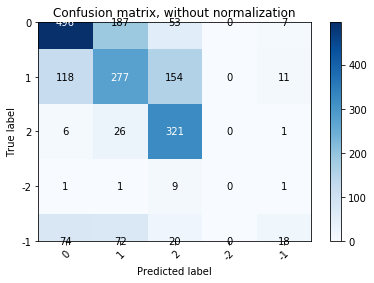

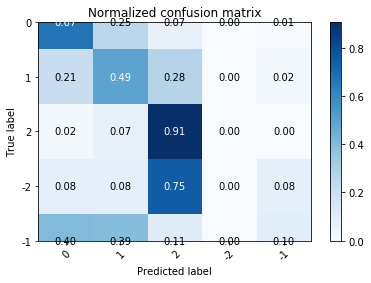

In [58]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_lstm, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_lstm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[357 234  25   4 123]
 [ 32 368 103   6  51]
 [  3  60 288   1   2]
 [  1   3   3   4   1]
 [ 12  43  10   3 116]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.48 0.31 0.03 0.01 0.17]
 [0.06 0.66 0.18 0.01 0.09]
 [0.01 0.17 0.81 0.   0.01]
 [0.08 0.25 0.25 0.33 0.08]
 [0.07 0.23 0.05 0.02 0.63]]
AxesImage(54,36;334.8x217.44)


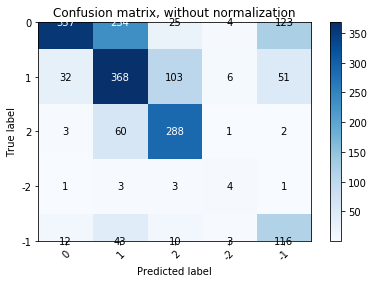

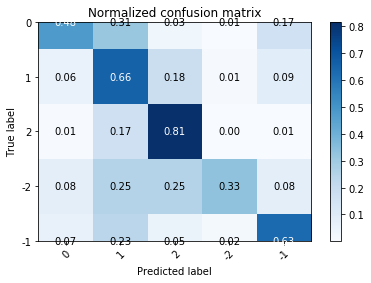

In [59]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_cnn, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_cnn, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()